In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [2]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu

In [3]:
## Find all the tiffiles in the tif path
# File I/O is pipelined, so the data doesn't have to be on a fast SSD 
# single HDDs or reasonably fast network drives should work without much difference in speed 
tif_path = r'/mnt/md0/data/Coconut'
tifs = tfu.get_tif_paths(tif_path)

In [4]:
tifs = tifs[:5]

In [5]:
# Set the mandatory parameters
params = {
    # volume rate
    'fs': tfu.get_vol_rate(tifs[0]),
    # planes to analyze. 0 is deepest, 30 is shallowest (corrected for ScanImage channel IDs)
    # you should keep all the planes to do crosstalk estimation! 
    'planes' : n.arange(30),
    # Decay time of the Ca indicator in seconds. 1.3 for GCaMP6s. This example is for GCamP8m
    'tau' : 1.3
}

### "Job" structure
The unimaginatively named `Job` structure is meant to contain all of the parameters, data, logs, and results for a single recording. It will be created in the root directory provided with the given name. All intermediate and final results will be saved in this directory, so I recommend using a fast SSD for this (and moving results to slow HDD once processing is complete).

All the print statements you see (and more) are also logged in `<job dir>/logfile.txt`. If you want things to look cleaner, reduce the verbosity to 2 (full logs will still be in the logfile).

To load a previously created job (to do more processing or load results), set `create=False`. If `create=True` but there exists another job of the same name in the root directory, it will either overwrite the parameters of the previous job or throw an error (depending on the `overwrite` parameter). Note, overwriting isn't as catastrophic as it sounds since data isn't deleted and remains accessible, but you might lose the saved parameters and some metadata.

In [6]:
# Create the job
job = Job('/mnt/md0/runs','Full-Demo-Coconut', tifs = tifs,
          params=params, create=False, overwrite=True, verbosity = 3)

   Found and loaded params from /mnt/md0/runs/s3d-Full-Demo-Coconut/params.npy


## Initial pass
This pass takes a few files (`n_init_files`, usually ~200-300 frames is enough) and does the following:
- estimates the crosstalk coefficient between the lower set of 15 planes and the higher 15 planes
- computes the shifts between successive planes caused by the xy-shift of the light beads
- estimates the optimal number of pixels that overlap between successive strips, so they can be fused together
- calculates a "reference volume" that will be used later in registration 

In [7]:
# optional parameters for initialization
# load 1 file to initialize
job.params['n_init_files'] = 1
# If set to None, use all of the frames in the loaded init files 
# if your files are really big, set this to <300
job.params['init_n_frames'] = 100

# Set to None to auto-compute the crosstalk coefficient
# You can set a float value between 0-1 (usually around 0.1-0.3) to override the calculation
job.params['override_crosstalk'] = None
# number of processors to use
job.params['n_proc_corr'] = 70
job.params['fuse_shift_override'] = 1

In [8]:
# %%time
# # This step only uses `n_init_files` files, so the  runtime will stay the same even with larger recordings
# # soon this will also be gpu-ified to be faster!
# job.run_init_pass()

In [9]:
summary = job.load_summary()

## Registration
First, we do registration over time of the  xy-drift caused by brain movement. This is similar to Suite2P registratrion, it does rigid registration followed by non-rigid registration. This is accelerated on the GPU. Suite2P registration parameters can be changed, see `default_params.py` for a list of all parameters related to registration. After you have registered, you can load the registered fused movie into memory and take a look at the mean image. I suggest cropping the dark edges if you have any as shown in the cells below.

If you run out of gpu memory, try reducing the `gpu_reg_batchsize` parameter. I have a A4500 with 20GB memory which works well with a batchsize of 10.

In [10]:
# If you have large tiffs, split the large tiffs into files of size 100 after registration
job.params['split_tif_size'] = 100
job.params['gpu_reg_batchsize'] = 10

In [13]:
job.params['reg_norm_frames'] = True

In [15]:
%%time
job.register_gpu(tifs = job.tifs[:1], max_gpu_batches = 2)

      Found dir /mnt/md0/runs/s3d-Full-Demo-Coconut/registered_fused_data with tag registered_fused_data
   Overriding fuse shift value to 1
Will analyze 1 tifs in 1 batches
   Enforcing positivity
   Launching IO thread
         Memory at batch 0.  Total Used: 234.752 GB, Virtual Available: 284.130 GB, Virtual Used: 219.066 GB, Swap Used: 015.686 GB
      Loading /mnt/md0/data/Coconut/Max30_500umdeep_1p75by1p75mm_3umppix_9p86Hz_250mW_00001_00001.tif
Loading Batch 0 of 0


<tifffile.TiffFile 'Max30_500umdeep…_00001_00001.tif'> asarray failed to reshape (29580, 2414, 146) to (36000, 30, 2414, 146)
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in a

   Loaded 1 files, total 18.79 GB
   Batch 0 IO thread joined
         Memory after IO thread joinTotal Used: 253.525 GB, Virtual Available: 265.357 GB, Virtual Used: 237.839 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 272.353 GB, Virtual Available: 246.528 GB, Virtual Used: 256.668 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 253.525 GB, Virtual Available: 265.357 GB, Virtual Used: 237.839 GB, Swap Used: 015.686 GB
      Loaded batch of size (30, 986, 584, 584)
      Sending frames 0-10 to GPU for rigid registration
######

BEFORE RIGID: 0.5p: -22.000 99.5p: 173.000, Mean: -3.368, Min: -57.000, Max:2556.000
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU Mov of shape 30, 10, 634, 659; 0.93 GB
         Allocating memory for shifted movie
mov_shifted before reg, min

In [16]:
offsets = job.load_registration_results()

In [17]:
mov_full = job.get_registered_movie('registered_fused_data','f')[:,:500]
im_full = mov_full[:,:300].mean(axis=1).compute()

In [18]:
mov_out = mov_full[:,:300].compute()

In [19]:
# tif = lbmio.load_and_stitch_tifs(job.tifs[:1], planes = job.params['planes'])

In [20]:
pidx = 10

pshifts = n.round(summary['plane_shifts']).astype(int)

pxmin = pshifts[:,1].min()

py, px = pshifts[pidx]
px = px - pxmin
nry, nrx =  584,584 #tif.shape[2:]
# raw_mean = tif[pidx,:300].mean(axis=0)
reg_mean_full = im_full[10]
reg_mean = reg_mean_full[py:py+nry, px:px+nrx]

In [ ]:

tfu.show_tif(mov_out[10,0:10].mean(axis=0), cbar=True, cbar_fontcolor='w')
tfu.show_tif(mov_out[10,0:10].mean(axis=0)[py:py+nry, px:px+nrx], cbar=True, cbar_fontcolor='w')

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f907648e340>)

In [18]:
tif = lbmio.load_and_stitch_tifs(job.tifs[:1], planes = job.params['planes'])

Loading /mnt/md0/data/Coconut/Max30_500umdeep_1p75by1p75mm_3umppix_9p86Hz_250mW_00001_00001.tif


<tifffile.TiffFile 'Max30_500umdeep…_00001_00001.tif'> asarray failed to reshape (29580, 2414, 146) to (36000, 30, 2414, 146)


Loaded 1 files, total 18.79 GB


In [63]:
pidx = 10

In [64]:
pshifts = n.round(summary['plane_shifts']).astype(int)

In [82]:
pxmin = pshifts[:,1].min()

In [85]:
py, px = pshifts[pidx]
px = px - pxmin
nry, nrx = tif.shape[2:]
raw_mean = tif[pidx,:300].mean(axis=0)
reg_mean_full = im_full[10]
reg_mean = reg_mean_full[py:py+nry, px:px+nrx]

(None, <Axes: >, <matplotlib.image.AxesImage at 0x7fb54b534a00>)

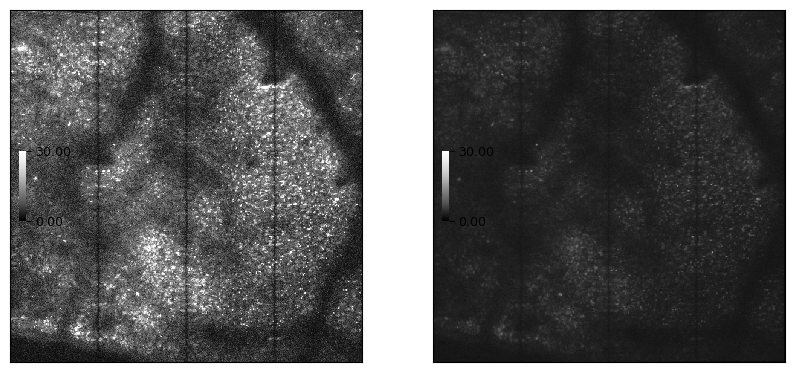

In [89]:
f,axs = plt.subplots(1,2, figsize=(10,5))
vminmax = (0,30)
tfu.show_tif(raw_mean - raw_mean.min(), ax=axs[0], vminmax=vminmax, cbar=True)
tfu.show_tif(reg_mean, ax=axs[1], vminmax=vminmax, cbar=True)

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.30800e+03, 1.62700e+03, 8.78560e+04, 1.72677e+05, 5.99210e+04,
        1.30430e+04, 3.10100e+03, 9.66000e+02, 3.13000e+02, 1.17000e+02,
        6.60000e+01, 2.90000e+01, 1.30000e+01, 1.30000e+01, 3.00000e+00,
        3.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]),
 array([-20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,
         -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
         13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21

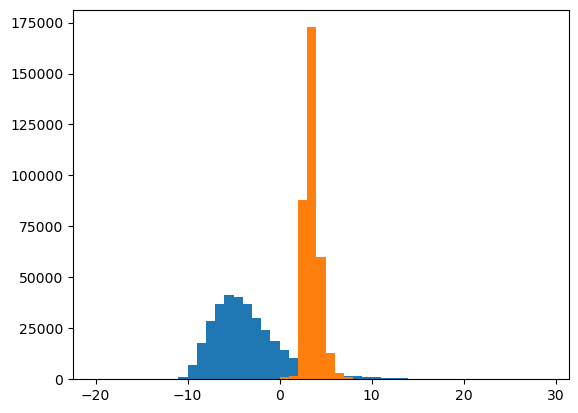

In [93]:
plt.hist(raw_mean.flatten(), bins=n.arange(-20,30))
plt.hist(reg_mean.flatten(), bins=n.arange(-20,30))

In [94]:
from suite3d import register_gpu as reg_gpu

In [100]:
mov_cpu = tif[:, :200]

In [129]:
idx0 = 0; idx1 = 40
refs_and_masks     = summary['refs_and_masks']
mask_mul, mask_offset, ref_2ds = n.stack([r[:3] for r in refs_and_masks],axis=1)
mask_mul_nr, mask_offset_nr, ref_nr = n.stack([r[3:] for r in refs_and_masks],axis=1)
min_pix_vals = summary['min_pix_vals']
max_rigid_shift = job.params['max_rigid_shift_pix']    
all_ops            = summary['all_ops']
rmins = n.array([op['rmin'] for op in all_ops])
rmaxs = n.array([op['rmax'] for op in all_ops])
xpad               = summary['xpad']
ypad               = summary['ypad']
fuse_shift = summary['fuse_shift']
new_xs             = summary['new_xs']
old_xs             = summary['og_xs']
fuse_strips=True

In [130]:
crosstalk_coeff = summary['crosstalk_coeff']

In [131]:

mov_shifted_gpu, ymaxs_rr_gpu, xmaxs_rr_gpu = reg_gpu.rigid_2d_reg_gpu(mov_cpu[:,idx0:idx1], 
                        mask_mul, mask_offset, 
                        ref_2ds, max_reg_xy=max_rigid_shift,  min_pix_vals=min_pix_vals,
                        rmins=rmins, rmaxs=rmaxs, crosstalk_coeff=crosstalk_coeff, shift=True,
                        xpad=xpad, ypad=ypad, fuse_shift=fuse_shift, new_xs=new_xs, old_xs=old_xs,
                        fuse_and_pad = fuse_strips)

Loaded mov and masks to GPU for rigid reg in 0.50 sec
Subtracting min pix vals to enforce positivity
Subtracting crosstalk
Fusing and padding movie
GPU Mov of shape 30, 40, 634, 659; 3.74 GB
GPU RAM: 3 blocks allocated, 5.66 / 6.13 GB used
Allocating memory for shifted movie
GPU RAM: 3 blocks allocated, 7.53 / 7.99 GB used
Registering plane 0
Shifting plane 0
Registering plane 1
Shifting plane 1
Registering plane 2
Shifting plane 2
Registering plane 3
Shifting plane 3
Registering plane 4
Shifting plane 4
Registering plane 5
Shifting plane 5
Registering plane 6
Shifting plane 6
Registering plane 7
Shifting plane 7
Registering plane 8
Shifting plane 8
Registering plane 9
Shifting plane 9
Registering plane 10
Shifting plane 10
Registering plane 11
Shifting plane 11
Registering plane 12
Shifting plane 12
Registering plane 13
Shifting plane 13
Registering plane 14
Shifting plane 14
Registering plane 15
Shifting plane 15
Registering plane 16
Shifting plane 16
Registering plane 17
Shifting pl

In [132]:
mov_shifted_cpu = mov_shifted_gpu.get()

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7fb5424618e0>)

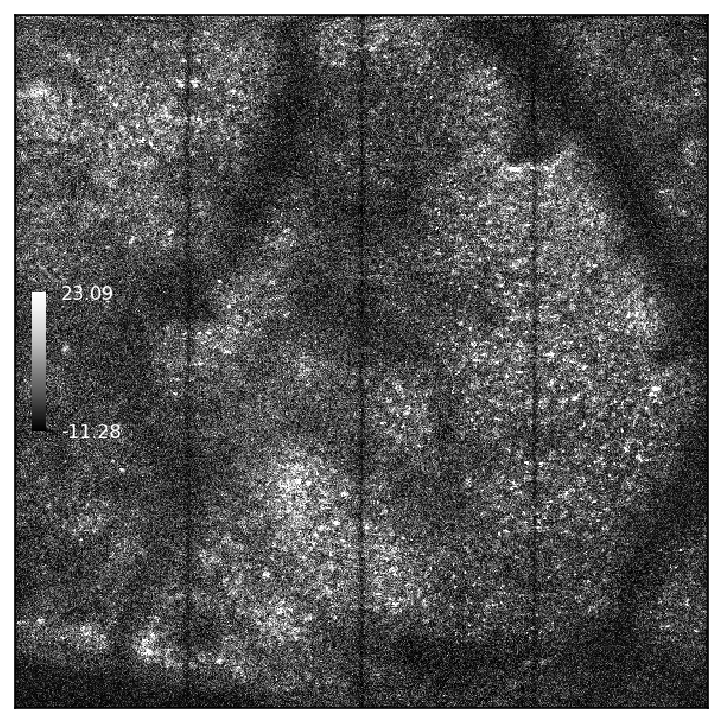

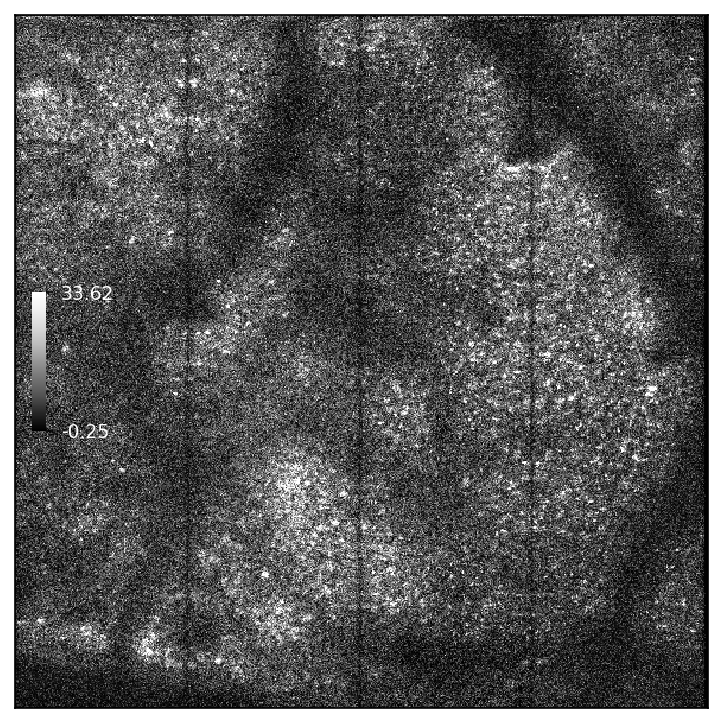

In [139]:

tfu.show_tif(mov_shifted_cpu[:,10].mean(axis=0)[py:py+nry, px:px+nrx], cbar=True, cbar_fontcolor='w')

In [145]:

snr_thresh = all_ops[0]['snr_thresh']
yblocks, xblocks = all_ops[0]['yblock'], all_ops[0]['xblock']
NRsm = all_ops[0]['NRsm'].astype(n.float32)

nblocks = all_ops[0]['nblocks']
max_shift_nr = 5


nr_npad            = job.params.get('nr_npad', 3)
nr_subpixel        = job.params.get('nr_subpixel', 10)
nr_smooth_iters    = job.params.get('nr_smooth_iters', 2)

In [147]:
ymaxs_nr_gpu, xmaxs_nr_gpu, snrs = reg_gpu.nonrigid_2d_reg_gpu(mov_shifted_gpu, mask_mul_nr[:,:,0], mask_offset_nr[:,:,0],
                          ref_nr[:,:,0], yblocks, xblocks, snr_thresh, NRsm, rmins, rmaxs,
                          max_shift=max_shift_nr, npad=nr_npad, n_smooth_iters=nr_smooth_iters, subpixel=nr_subpixel,
                          )

Allocated GPU array for non-rigid reg in 0.16 sec
Blocked movie is 9.38GB
GPU RAM: 10 blocks allocated, 12.18 / 17.37 GB used
Clipped movie in 0.01 sec
Split movie into blocks in 0.00 sec
Completed FFT of blocks and computed phase correlations in 0.46 sec
Iter 0: 41324/76800 blocks below SNR thresh
Iter 1: 25889/76800 blocks below SNR thresh
Iter 1: 20591/76800 blocks below SNR thresh
Computed SNR and smoothed phase corrs in 1.05 sec
Computed subpixel shifts in 0.02 sec
GPU RAM: 10 blocks allocated, 12.35 / 13.54 GB used


In [150]:
ymaxs_nr_cpu = ymaxs_nr_gpu.get()
xmaxs_nr_cpu = xmaxs_nr_gpu.get()

In [151]:
mov_nr_shifted = n.zeros_like(mov_shifted_cpu)

In [154]:
nz = mov_shifted_cpu.shape[1]

In [156]:

from suite2p.registration import nonrigid

In [158]:
mov_nr_shifted.shape

(40, 30, 634, 659)

In [159]:
for zidx in range(nz):
    # print("SHIFITNG: %d" % zidx)
    mov_nr_shifted[idx0:idx1,zidx] = nonrigid.transform_data(mov_shifted_cpu[:,zidx], nblocks, 
                                                      xblock=xblocks, yblock=yblocks, ymax1=ymaxs_nr_cpu[:,zidx],
                                                      xmax1=xmaxs_nr_cpu[:,zidx])

In [163]:
mov_nr_shifted.shape

(40, 30, 634, 659)

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7fb54232a0d0>)

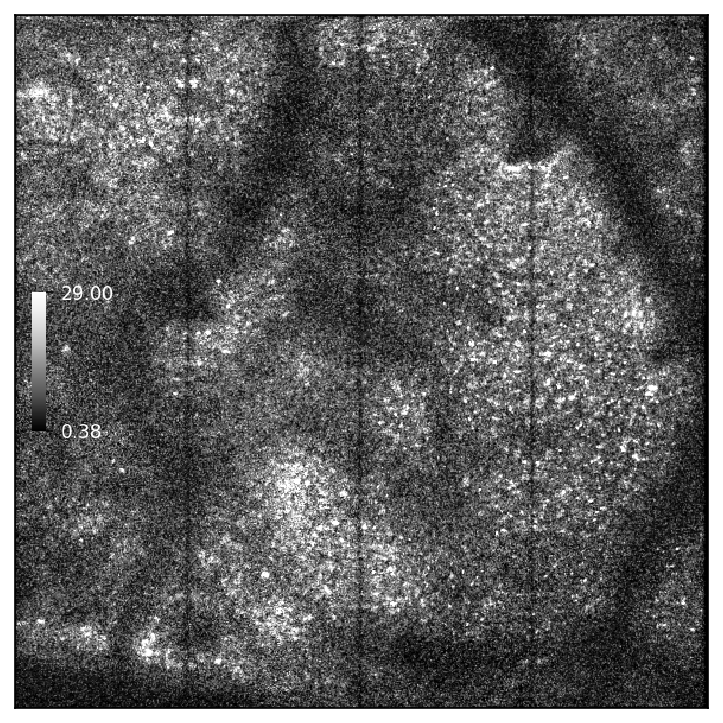

In [162]:

tfu.show_tif(mov_nr_shifted[:,10].mean(axis=0)[py:py+nry, px:px+nrx], cbar=True, cbar_fontcolor='w')

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7fb540080d60>)

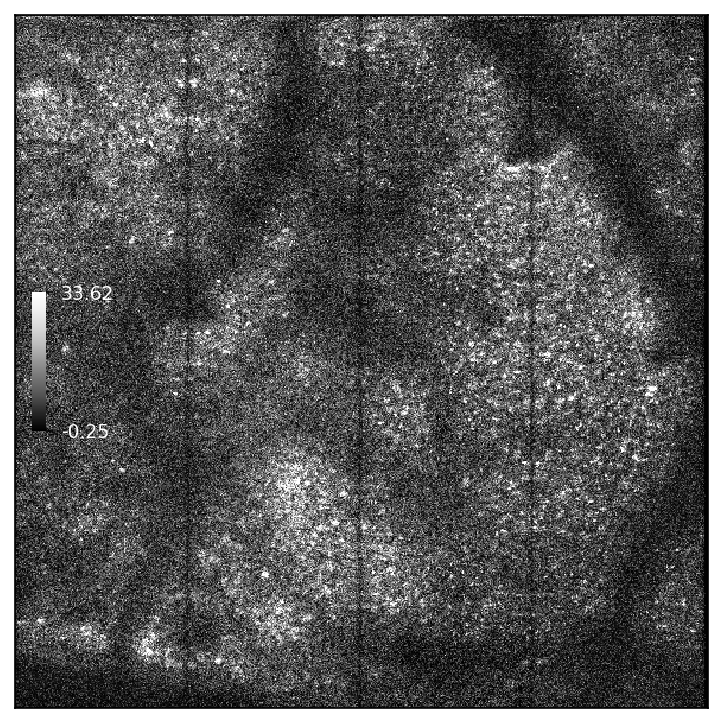

In [161]:

tfu.show_tif(mov_shifted_cpu[:,10].mean(axis=0)[py:py+nry, px:px+nrx], cbar=True, cbar_fontcolor='w')